**Wikipedia -api**

In [11]:
!pip install wikipedia-api  # Install wikipedia-api using pip
!pip install faiss-cpu # Install the faiss library-Vector database


In [12]:
import pandas as pd
from transformers import pipeline
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import wikipediaapi

# Define a descriptive user agent string
user_agent = "MyWikipediaApp/1.0 (MyEmail@example.com)"

# Step 1: Initialize Wikipedia API and Fetch Content
def fetch_wikipedia_content(page_name, lang='en'):
    # Pass the user_agent argument when creating the Wikipedia object
    wiki = wikipediaapi.Wikipedia(user_agent=user_agent, language=lang)  # Added user_agent here
    page = wiki.page(page_name)
    if not page.exists():
        print(f"Page '{page_name}' does not exist.")
        return None
    return page.text

# Chunk text into smaller segments
def chunk_text(text, max_chunk_size=500):
    """
    Splits large text into smaller chunks of the specified size.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_chunk_size):
        chunks.append(" ".join(words[i:i + max_chunk_size]))
    return chunks

# Build FAISS index
def build_faiss_index(chunks):
    """
    Builds a FAISS index from the text chunks.
    """
    embeddings = embedding_model.encode(chunks)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(np.array(embeddings, dtype=np.float32))
    return index, embeddings

# Query FAISS index
def query_faiss_index(query, index, chunks, top_k=5):
    """
    Queries the FAISS index to retrieve top-matching text chunks.
    """
    query_embedding = embedding_model.encode([query])
    _, indices = index.search(np.array(query_embedding, dtype=np.float32), top_k)
    results = [chunks[i] for i in indices[0]]
    return results


# Summarize results
def summarize_results(results):
    """
    Summarizes the results retrieved from the FAISS index.
    """
    combined_text = " ".join(results)

    # Explicitly set max_length for truncation before passing to summarizer
    max_input_length = summarizer.model.config.max_position_embeddings
    truncated_text = combined_text[:max_input_length] #Truncate the text before to avoid exceeding the limit

    # Enforce truncation and set max_length for summarization
    summary = summarizer(truncated_text, max_length=500, min_length=30,
                         do_sample=False, truncation=True, num_beams=5,  early_stopping=True )
    return summary[0]['summary_text']


# Save to CSV
def save_to_csv(filename, data, columns):
    """
    Saves data to a CSV file.
    """
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)

# Main Function
if __name__ == "__main__":
    # Initialize summarization and embedding models
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Define topics
    topics = ["Thyroid", "Cells", "Brain", "Kidney", "Liver",
              "Heart", "Lungs", "Diabetes", "Cancer", "Obesity"]

    # Step 1: Fetch and preprocess content
    full_content = []
    summarized_content = []
    all_chunks = []
    for topic in topics:
        print(f"Fetching content for topic: {topic}")
        content = fetch_wikipedia_content(topic)
        if content:
            full_content.append({"Topic": topic, "Content": content})
            chunks = chunk_text(content)
            all_chunks.extend(chunks)
            summary = summarize_results([content])
            summarized_content.append({"Topic": topic, "Summary": summary})

    # Step 2: Build FAISS index
    print("Building FAISS index...")
    index, embeddings = build_faiss_index(all_chunks)

    # Step 3: Query and summarize
    user_query = input("Enter your query: ")
    top_results = query_faiss_index(user_query, index, all_chunks)
    summary = summarize_results(top_results)

    print("\nSummary:\n", summary)

    # Prepare query results for CSV
    query_results = [{"Query": user_query, "Result": result} for result in top_results]
    query_summary = [{"Query": user_query, "Summary": summary}]

    # Save to CSV
    print("Saving data to CSV files...")
    save_to_csv("full_content.csv", full_content, ["Topic", "Content"])
    save_to_csv("query_results.csv", query_results, ["Query", "Result"])
    save_to_csv("query_summary.csv", query_summary, ["Query", "Summary"])


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Fetching content for topic: Thyroid


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Your max_length is set to 500, but your input_length is only 246. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=123)


Fetching content for topic: Cells


Your max_length is set to 500, but your input_length is only 262. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=131)


Fetching content for topic: Brain


Your max_length is set to 500, but your input_length is only 211. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=105)


Fetching content for topic: Kidney


Your max_length is set to 500, but your input_length is only 234. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=117)


Fetching content for topic: Liver


Your max_length is set to 500, but your input_length is only 206. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=103)


Fetching content for topic: Heart


Your max_length is set to 500, but your input_length is only 219. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=109)


Fetching content for topic: Lungs


Your max_length is set to 500, but your input_length is only 211. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=105)


Fetching content for topic: Diabetes


Your max_length is set to 500, but your input_length is only 203. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=101)


Fetching content for topic: Cancer


Your max_length is set to 500, but your input_length is only 208. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=104)


Fetching content for topic: Obesity


Your max_length is set to 500, but your input_length is only 206. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=103)


Building FAISS index...
Enter your query: why cancer cells produced in body.write 4 reasons?


Your max_length is set to 500, but your input_length is only 205. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=102)



Summary:
 Tobacco use is the cause of about 22% of cancer deaths. Another 10% are due to obesity, poor diet, lack of physical activity or excessive alcohol consumption. Infection with specific viruses, bacteria and parasites is an environmental factor.
Saving data to CSV files...


**BERT-ANALYSE LOGICAL STRUCTURE**

In [15]:
!pip install transformers torch pandas spacy

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summarized data saved to summarized_output_with_bert.csv


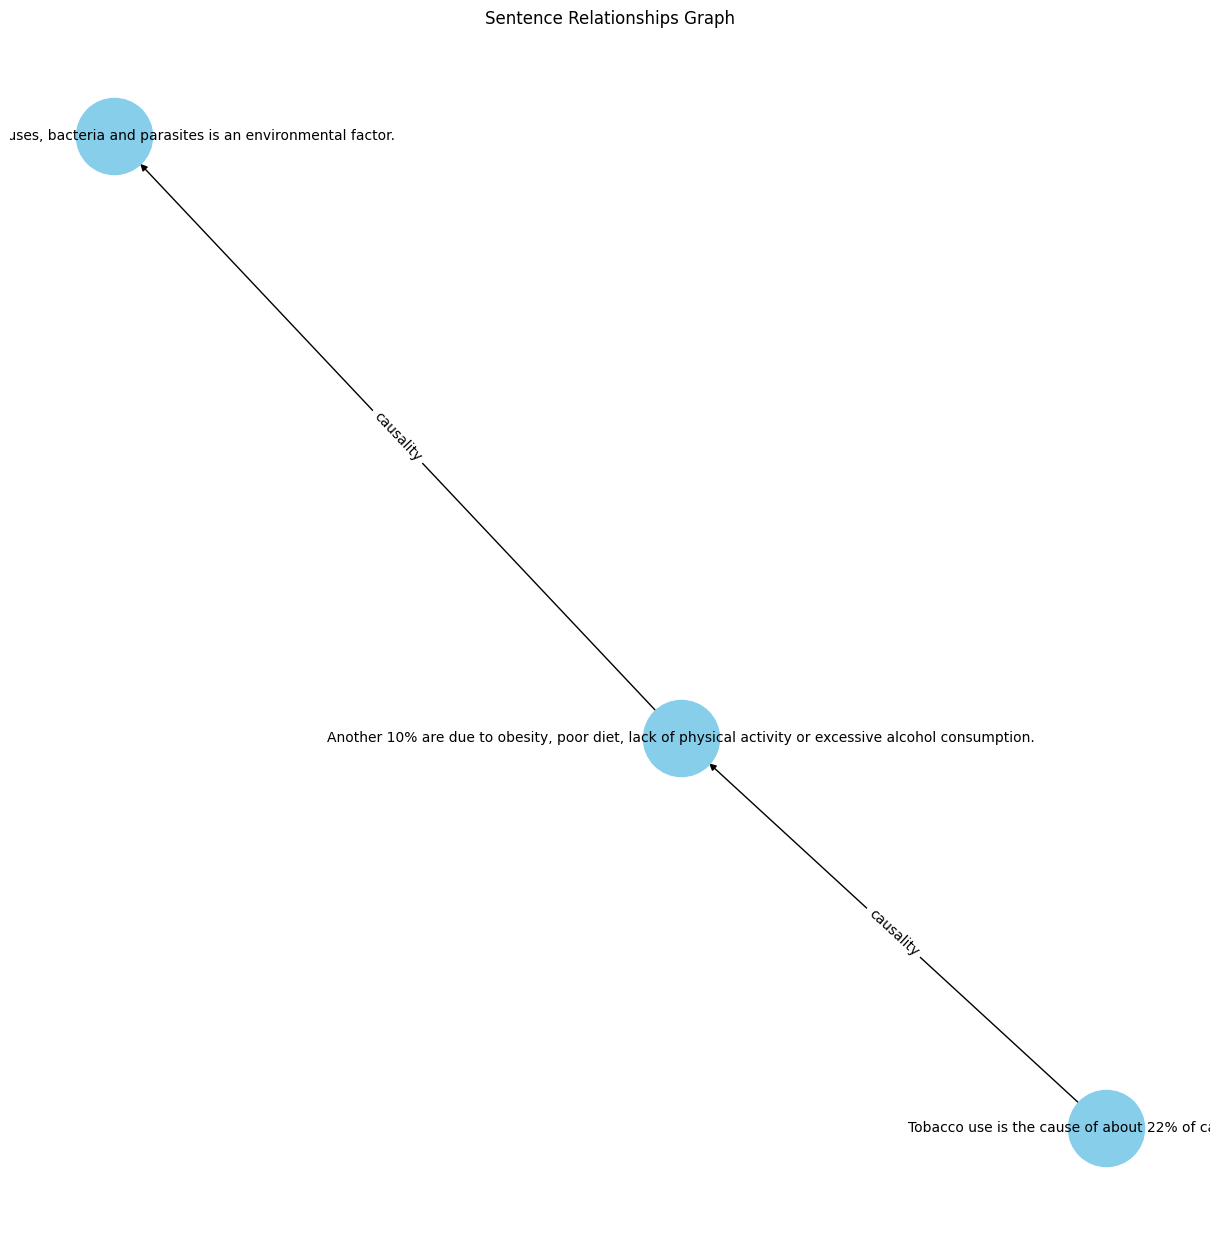

In [17]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load spaCy model for sentence segmentation and dependency parsing
nlp = spacy.load("en_core_web_sm")

# Define a BERT Dataset Class for Relationship Classification
class RelationshipDataset(torch.utils.data.Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            sentence[0], sentence[1],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].flatten()
        attention_mask = encoding["attention_mask"].flatten()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Define relationship classification model (fine-tuned BERT)
class RelationshipClassifier(torch.nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(RelationshipClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)  # 4 relationships

    def forward(self, input_ids, attention_mask, token_type_ids=None): # Add token_type_ids as an argument
        outputs = self.bert(input_ids, attention_mask=attention_mask)  # Remove token_type_ids
        return outputs

# Define relationship mapping
relationship_mapping = {
    0: "causality",
    1: "condition",
    2: "sequence",
    3: "comparison",
    4: "other"
}

# Function to classify relationships
def classify_relation_with_bert(sentences, model, tokenizer):
    model.eval()

    inputs = tokenizer(sentences[0], sentences[1], return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get prediction
    predictions = torch.argmax(outputs.logits, dim=-1)

    return relationship_mapping[predictions.item()]

# Extract text segments (sentences) from the summary
def extract_text_segments(text):
    doc = nlp(text)
    segments = [sent.text.strip() for sent in doc.sents]
    return segments

# Function to identify the type of relationship in each sentence
def identify_relationship_type(sentence):
    # Parse sentence with spaCy
    doc = nlp(sentence)

    # Initialize relationship type as "other"
    relationship_type = "other"

    # Check for causality (e.g., "because", "due to", "cause")
    if any(tok.dep_ == "prep" and tok.text in ["because", "due", "cause"] for tok in doc):
        relationship_type = "causality"

    # Check for condition (e.g., "if", "unless")
    elif any(tok.dep_ == "prep" and tok.text in ["if", "unless", "when"] for tok in doc):
        relationship_type = "condition"

    # Check for sequence (e.g., "first", "then", "next")
    elif any(tok.dep_ == "advmod" and tok.text in ["first", "then", "next", "after"] for tok in doc):
        relationship_type = "sequence"

    # Check for comparison (e.g., "like", "as")
    elif any(tok.dep_ == "prep" and tok.text in ["like", "as"] for tok in doc):
        relationship_type = "comparison"

    return relationship_type

# Function to create a graph with relationships
def create_graph_with_relationships(segments, relationships):
    G = nx.DiGraph()  # Directed graph for logical flow

    # Add nodes with text (sentences)
    for i, segment in enumerate(segments):
        G.add_node(i, text=segment)

    # Add edges with relationship labels
    for i in range(len(relationships)):
        G.add_edge(i, i + 1, relation=relationships[i])

    return G

# Function to visualize the graph with relationships
def visualize_graph(graph):
    pos = nx.spring_layout(graph)  # Layout for nodes
    labels = nx.get_node_attributes(graph, 'text')
    edge_labels = nx.get_edge_attributes(graph, 'relation')

    # Draw nodes and labels
    plt.figure(figsize=(12, 12))
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue", font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Sentence Relationships Graph")
    plt.show()

# Process CSV and classify relationships
def process_and_generate_summary(file_path, output_file, model, tokenizer):
    df = pd.read_csv(file_path)

    summarized_data = []
    all_graphs = []  # To store graphs for visualization

    for _, row in df.iterrows():
        topic = row.get("Query", "Unknown Topic")
        text = row["Summary"]

        # Extract segments (sentences)
        segments = extract_text_segments(text)

        relationships = []
        for i in range(len(segments) - 1):
            sentences_pair = (segments[i], segments[i + 1])
            relation = classify_relation_with_bert(sentences_pair, model, tokenizer)
            relationships.append(relation)

        # Store summarized data
        for i, relation in enumerate(relationships):
            # Classifying the relationship for text type (causality, sequence, condition, comparison,or other)
            type_of_text = identify_relationship_type(segments[i])  # Identify the type of relationship

            reason = f"The relationship between sentence {i+1} and sentence {i+2} is {relation}."

            summarized_data.append({
                "Topic": topic,
                "Original_Text": segments[i],
                "Next_Text": segments[i + 1],
                "Relationship_Type": relation,
                "Type_of_Text": type_of_text,  # Add Type of Text column
                "Reason_for_Summary": reason
            })

        # Create graph for this text
        graph = create_graph_with_relationships(segments, relationships)
        all_graphs.append(graph)  # Store for later visualization

    # Save to CSV
    summarized_df = pd.DataFrame(summarized_data)
    summarized_df.to_csv(output_file, index=False)
    print(f"Summarized data saved to {output_file}")

    # Visualize the last graph in the collection (optional)
    visualize_graph(all_graphs[-1])  # Visualize the last processed graph

# Main function to load model, tokenizer, and process the CSV
def main(csv_file_path, output_file_path):
    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = RelationshipClassifier()

    # Here, we assume that the model is pre-trained or fine-tuned
     # model.load_state_dict(torch.load("fine_tuned_bert_model.pth"))

    # Process and generate the summary CSV
    process_and_generate_summary(csv_file_path, output_file_path, model, tokenizer)

# Run the program
csv_file_path = "/content/query_summary.csv"  # Replace with your input CSV file path
output_file_path = "summarized_output_with_bert.csv"  # Path to save the output

main(csv_file_path, output_file_path)
